In [25]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split


In [26]:
path_to_data = "C:\\Users\\ryanz\\Documents\\CS528\\project\\real_time_svm\\data"

data = {}
gestures = ["play", "pause", "skip", 'rewind']

for filename in os.listdir(path_to_data):
    df = pd.read_csv(path_to_data + "\\" + filename)
    df = df.reset_index().rename(columns={'index': 'Sample Num'})

    for gesture in gestures:
        if gesture in filename:
            if gesture not in data:
                data[gesture] = {filename: df}
            else:
                data[gesture][filename] = df
                
    

    


In [27]:

max_length = 0
for gesture in data:
    for filename in data[gesture]:
        df = data[gesture][filename]
        max_length = max(max_length, df.shape[0])

X = []
y = []
scaler = MinMaxScaler()
target_length = max_length
print(target_length)
fitted = False

for gesture in data:
    for filename in data[gesture]:
        df = data[gesture][filename]
        vals = df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']].values.astype(np.float32)
        
        if not fitted:
            vals = scaler.fit_transform(vals)
            scaler_filename = 'scaler.pkl'
            with open(scaler_filename, "wb") as f:
                pickle.dump(scaler, f)

            fitted = True
        else:
            vals = scaler.transform(vals)
            
        #pad arrays with zeros
        if vals.shape[0] < target_length:
            padding = np.zeros((target_length - vals.shape[0], vals.shape[1]))
            vals = np.vstack((vals, padding))
        else:
            vals = vals[:target_length, :]
        
        X.append(vals.flatten())
        y.append(gesture)

X = np.array(X)
y = np.array(y)


300


In [28]:
def train_svm_cross_validated(X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    le = LabelEncoder()
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        
        svm_classifier = SVC(kernel='rbf')
        svm_classifier.fit(X_train, y_train)
        
        y_pred = svm_classifier.predict(X_test)
        
        y_test_encoded = le.fit_transform(y_test)
        y_pred_encoded = le.transform(y_pred)
        
        
        accuracies.append(accuracy_score(y_test_encoded, y_pred_encoded))
        precisions.append(precision_score(y_test_encoded, y_pred_encoded, average='macro'))
        recalls.append(recall_score(y_test_encoded, y_pred_encoded, average='macro'))
        f1s.append(f1_score(y_test_encoded, y_pred_encoded, average='macro'))
        
        
        
        
        print(f"Fold {i} accuracy: {accuracy_score(y_test_encoded, y_pred_encoded)}")
        
        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=gestures, yticklabels=gestures)
        plt.title('train')
        plt.xlabel('pred')
        plt.ylabel('actual')
        plt.show()
        
    return accuracies, precisions, recalls, f1s

In [29]:
def train_svm(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
    svm_classifier = SVC(kernel='linear')
    svm_classifier.fit(X_train, y_train)
    
    y_pred = svm_classifier.predict(X_test)
    
    
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    
    
    print(f"Accuracy: {accuracy}")
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=gestures, yticklabels=gestures)
    plt.title('train')
    plt.xlabel('pred')
    plt.ylabel('actual')
    plt.show()
    return accuracy, precision, recall, f1


In [30]:
def train_svm_no_test(X, y):
    svm_classifier = SVC(kernel='rbf', probability=True)
    svm_classifier.fit(X, y)    
    
    model_filename = "svm_model.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(svm_classifier, f)


    
    


### SVM

Accuracy: 1.0


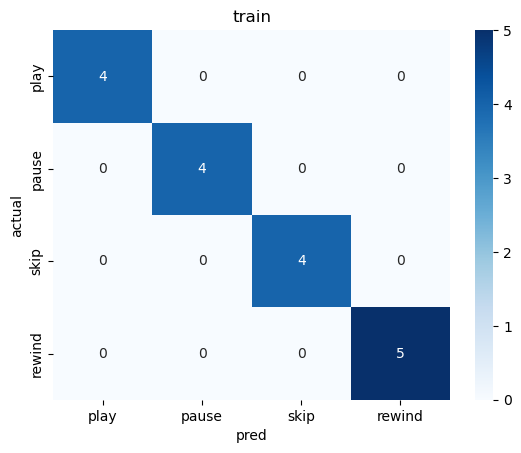

(1.0, 1.0, 1.0, 1.0)

In [31]:
train_svm(X, y)

In [32]:
train_svm_no_test(X, y)